In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import os
from tqdm import tqdm

df = pd.read_csv("../../data/data/train-metadata.csv", low_memory=False)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(df.head)
benign = df[df['target'] == 0]
malignant  = df[df['target'] == 1]
    
benign_sampled = benign.sample(n=3000, random_state=42)
subset_df = pd.concat([benign_sampled, malignant ])
    
print(f"Class 0 samples: {len(benign_sampled)}")
print(f"Class 1 samples: {len(malignant )}")
print(f"Total samples: {len(subset_df)}")

missing_percentages = (subset_df.isnull().sum() / len(subset_df)) * 100
columns_to_keep = missing_percentages[missing_percentages < 50].index
skin_cancer_df = subset_df[columns_to_keep]

features_to_drop = [
    'iddx_full',
    'iddx_1',
    'iddx_2',
    'iddx_3',
    'iddx_4',
    'iddx_5',
    'patient_id',
    'lesion_id',
    'attribution',
    'copyright_license'
]

# We do this because depending on the seed and shuffle, the columns that get dropped will be different!
for col in features_to_drop:
    if col in skin_cancer_df.columns:
        print(f"Dropping column: {col}")
        skin_cancer_df = skin_cancer_df.drop(columns=[col])

numeric_columns = skin_cancer_df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = skin_cancer_df.select_dtypes(include=['object', 'category']).columns

skin_cancer_df[numeric_columns] = skin_cancer_df[numeric_columns].fillna(
    skin_cancer_df[numeric_columns].median())
skin_cancer_df[categorical_columns] = skin_cancer_df[categorical_columns].fillna(
    skin_cancer_df[categorical_columns].mode().iloc[0])

for col in categorical_columns:
    if col != 'isic_id':
        le = LabelEncoder()
        skin_cancer_df[col] = le.fit_transform(skin_cancer_df[col])

expected_samples = len(skin_cancer_df)
image_features = np.zeros((expected_samples, 128 * 128 * 3))
valid_indices = []

for idx, isic_id in tqdm(enumerate(skin_cancer_df['isic_id']), total=expected_samples):
    try:
        file_path = os.path.join("../../data/data/train-image/image", f"{isic_id}.jpg")
        if os.path.exists(file_path):
            img = mpimg.imread(file_path)
            img_resized = np.array(Image.fromarray(img).resize((128, 128)))
            image_features[idx] = img_resized.reshape(-1)
            valid_indices.append(idx)
    except Exception as e:
        print(f"Error processing {isic_id}: {str(e)}")
        continue

if not valid_indices:
    raise ValueError("No valid images were processed")

image_features = image_features[valid_indices]

image_features_scaled = image_features / 255.0
n_components = 150
pca = PCA(n_components=n_components, random_state=42)
image_features_pca = pca.fit_transform(image_features_scaled)

pca_columns = [f'pca_{i}' for i in range(n_components)]
image_df = pd.DataFrame(image_features_pca, columns=pca_columns)

explained_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"\nVariance explained by {n_components} components: {explained_variance[-1]}")

X = pd.concat([
    skin_cancer_df.drop(['isic_id', 'target'], axis=1).reset_index(drop=True),
    image_df
], axis=1)
y = skin_cancer_df['target'].reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

<bound method NDFrame.head of              isic_id  target  patient_id  age_approx     sex  \
0       ISIC_6973879       0  IP_3201881        55.0  female   
1       ISIC_5407194       0  IP_5714646        40.0    male   
2       ISIC_5273739       0  IP_6391213        85.0    male   
3       ISIC_0802250       0  IP_6611217        55.0    male   
4       ISIC_8084953       0  IP_6957489        70.0    male   
...              ...     ...         ...         ...     ...   
401054  ISIC_6502755       0  IP_7965642        60.0    male   
401055  ISIC_9129069       0  IP_2889176        45.0  female   
401056  ISIC_3342513       0  IP_9577633        50.0    male   
401057  ISIC_3720179       0  IP_3751225        75.0    male   
401058  ISIC_3097113       0  IP_2573038        50.0    male   

       anatom_site_general  clin_size_long_diam_mm          image_type  \
0          lower extremity                    3.15  TBP tile: close-up   
1          posterior torso                    3.03  T

100%|██████████████████████████████████████| 3393/3393 [00:08<00:00, 410.87it/s]



Variance explained by 150 components: 0.9555862336437281


In [3]:
from sklearn.tree import DecisionTreeClassifier
skin_cancer_decisiontree = DecisionTreeClassifier(class_weight='balanced', max_depth=5, min_samples_split=10,min_samples_leaf=5, random_state=42)
from sklearn.model_selection import cross_val_score
# Perform 5-Fold Cross-Validation
scores = cross_val_score(skin_cancer_decisiontree, X, y, cv=5, scoring='accuracy')

# Print the results
print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())
print("Standard Deviation:", scores.std())

Cross-Validation Scores: [0.91310751 0.89543446 0.84977909 0.89528024 0.91740413]
Mean Accuracy: 0.8942010852329254
Standard Deviation: 0.023965950580562424


In [5]:
skin_cancer_decisiontree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=5,
                       min_samples_split=10, random_state=42)

In [21]:
y_predict = (skin_cancer_decisiontree.predict_proba(X_test)[:, 1] > 0.3) 
accuracy = accuracy_score(y_test, y_predict)
print(accuracy)

0.8321060382916053


Accuracy: 0.8321060382916053
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.84      0.90       600
           1       0.39      0.80      0.53        79

    accuracy                           0.83       679
   macro avg       0.68      0.82      0.71       679
weighted avg       0.90      0.83      0.85       679

Confusion Matrix:


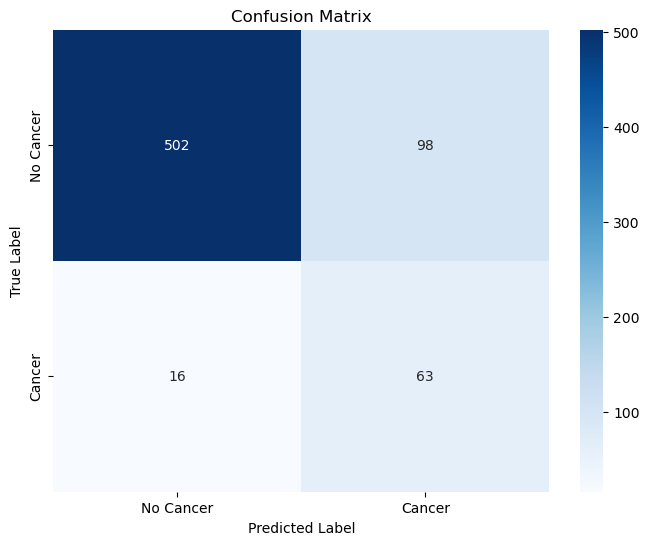

In [17]:
# Evaluate predictions
accuracy = accuracy_score(y_test, y_predict)
print(f"Accuracy: {accuracy}")

print("Classification Report:")
print(classification_report(y_test, y_predict))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_predict)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Cancer', 'Cancer'],
            yticklabels=['No Cancer', 'Cancer'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

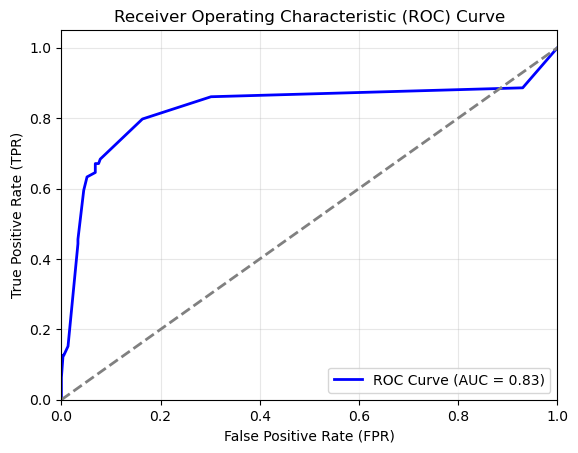

In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get the predicted probabilities for the positive class
y_prob = skin_cancer_decisiontree.predict_proba(X_test)[:, 1]  # Probability for the positive class

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()